### Imports

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neural_network import MLPRegressor
from scipy.stats import spearmanr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Gathering Data

In [ ]:
 # reading csv file
df = pd.read_csv("noaa_dataset.csv")

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,35,37,53,56,65,66,71,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,IMMA_VER,ATTM_CT,TIME_IND,LL_IND,...,SHIP_HEADING,COURSE_OVER_GROUND,SPD_OVER_GROUND,MAX_HT_SUM_LOAD,DEP_LOAD_IN,REL_WIND_DIR,REL_WIND_SPD,Unnamed: 82,Unnamed: 83,Unnamed: 84
0,3FPG6,2011-01-01T00:00:00,11.6,112.6,NaN,NaN,1,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9VRK,2011-01-01T00:00:00,11.2,110.5,NaN,NaN,1,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C6NT7,2011-01-01T00:00:00,17.4,119.9,NaN,NaN,1,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VRWQ2,2011-01-01T00:00:00,15.7,113.0,NaN,NaN,1,6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DQVH,2011-01-01T00:00:00,33.2,128.7,NaN,NaN,1,6,NaN,NaN,...,6.0,1.150000e+19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# information about the data
print("Dataframe Stats")
print("---------------")
print("NUM ROWS: " + str(df.shape[0]))
print("NUM COLS: " + str(df.shape[1]))
print("COLUMNS: " + str(df.columns))

Dataframe Stats
---------------
NUM ROWS: 40343
NUM COLS: 85
COLUMNS: Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'IMMA_VER', 'ATTM_CT', 'TIME_IND', 'LL_IND', 'SHIP_COURSE', 'SHIP_SPD',
       'NAT_SOURCE_IND', 'ID_IND', 'COUNTRY_CODE', 'WIND_DIR_IND', 'WIND_DIR',
       'WIND_SPD_IND', 'WIND_SPEED', 'VV_IND', 'VISIBILITY', 'PRES_WX',
       'PAST_WX', 'SEA_LVL_PRES', 'CHAR_PPP', 'AMT_PRES_TEND', 'IND_FOR_TEMP',
       'AIR_TEMP', 'IND_FOR_WBT', 'WET_BULB_TEMP', 'DPT_IND', 'DEW_PT_TEMP',
       'SST_MM', 'SEA_SURF_TEMP', 'TOT_CLD_AMT', 'LOW_CLD_AMT', 'LOW_CLD_TYPE',
       'HGT_IND', 'CLD_HGT', 'MID_CLD_TYPE', 'HI_CLD_TYPE', 'WAVE_PERIOD',
       'WAVE_HGT', 'SWELL_DIR', 'SWELL_PERIOD', 'SWELL_HGT', 'TEN_BOX_NUM',
       'ONE_BOX_NUM', 'DECK', 'SOURCE_ID', 'PLATFORM_ID', 'DUP_STATUS',
       'DUP_CHK', 'NIGHT_DAY_FLAG', 'TRIM_FLAG', 'NCDC_QC_FLAGS',
       'SOURCE_EXCLUSION_FLAG', 'OB_SOURCE', 'OB_PLATFORM', 'FM_CODE_VER',
       'STA_WX_IND', 'PAST_W

### Features Extraction

### Scientifically Relevant Data
The following variables represent scientifically relevant variables. These features were selected given previous studies documenting the associations between these variables and climate change.

We developed our model on a feature set including features evaluating data precision and consistency (for example PLATFORM_ID, ONE_BOX_NUM, and TEN_BOX_NUM). This was important to us since the NOAA changes its data reporting standards over time, and we wanted to account for this in case any changes occurred in the last decade. We manually filtered out indicator variables, since no dictionary was available to map the values of the indicator variables to numeric ranges.

 1. DATE: standard datetime format, coverted into "date_delta" value to express days since 01/01/2010.
 2. LATITUDE: distance north or south of the equator
 3. LONGITUDE: distance east or west of the prime meridian
 4. WIND_SPEED: unitless measurement of wind speed intensity. Known to be effected by air pressure, centripetal acceleration, Earth's rotation, and pressure gradient forces (PGFs). Some of these are hypothesized to have causal relationships with air temperature.
 5. SEA_LVL_PRES: describes air pressure of sea level relative to average atmospheric pressure (1013.25 millibars) 
 6. DEW_PT_TEMP: temperature that air needs to be cooled for the air to become fully saturated with vapor. Indicator of rain, air moisture, and atmospheric water.
 7. SEA_SURF_TEMP: the temperature along the ocean's surface. Water has a high specific heat, which makes large water bodies generally resilient to seasonal temperature gradients.
 8. SOURCE_ID: The category of ship/climate center where the data was collected.
 10. TOT_CLD_AMT: Intensity of cloud coverage such that sunlight is blocked on a scale of 0 to 10.
 11. WIND_DIR: direction (from 0 to 360 degrees) of wind measured in wind speed.
 12. ONE_BOX_NUM: one-degree box number representing the area coverage (as a 1x1 degree latitude/longitude square)
 13. TEN_BOX_NUM: ten-degree box number representing the area coverage (as a 10x10 degree latitude/longitude square)
 14. PLATFORM_ID: represents the type of ship where the data was collected
 15. DECK: An indicator variable for the type of data collection equipment available on the ship (assignment of specific number values is unclear).

 RESPONSE: AIR_TEMP: air temperature on that day in arbitrary/unknown units


# Initial Feature Selection
##### These features were selected given previous studies documenting the associations between these variables and climate change. 
##### Latitude, longitude, and date were selected for specificity of the data. Mainlad China spans 30 degrees of latitude and 60 degrees of longitude, covering numerous biomes with distinct weather patterns that affect air temperature. Many features were also interdependent on one another--for example, total cloud amount and cloud height, or sea surface temperature and sea level pressure.




In [ ]:
# manually selected columns based on scientific importance and need for data stanardization
columns = ['DATE', 'LATITUDE', 'LONGITUDE', 'WIND_SPEED', 'SEA_LVL_PRES', 'DEW_PT_TEMP', 'SEA_SURF_TEMP',
          'SOURCE_ID', 'TOT_CLD_AMT', 'ONE_BOX_NUM', 'TEN_BOX_NUM', 'PLATFORM_ID', 'DECK', 'WIND_DIR', 'AIR_TEMP']

print("Percent of rows with valid values in each column:")
for col in columns:
    print(col + ": " + str(1-df[col].isnull().sum()/40343))

Percent of rows with valid values in each column:
DATE: 1.0
LATITUDE: 1.0
LONGITUDE: 1.0
WIND_SPEED: 0.3402820811541035
SEA_LVL_PRES: 0.45678308504573284
DEW_PT_TEMP: 0.22090573333663832
SEA_SURF_TEMP: 0.7273132885506779
SOURCE_ID: 1.0
TOT_CLD_AMT: 0.2052648538779962
ONE_BOX_NUM: 1.0
TEN_BOX_NUM: 0.975782663659123
PLATFORM_ID: 1.0
DECK: 1.0
WIND_DIR: 0.3624916342364227
AIR_TEMP: 0.35024663510398335


### Data Cleaning

In [ ]:
# function to clean data via median substitution for delta time intervals of 100
X = df[columns]
# convert date to float
X['DATE'] = pd.to_datetime(X['DATE'])    
X['date_delta'] = (X['DATE'] - X['DATE'].min())  / np.timedelta64(1,'D')
X = X.drop(['DATE'], axis=1)
X = X.sort_values('date_delta')
X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,LATITUDE,LONGITUDE,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,WIND_DIR,AIR_TEMP,date_delta
0,11.60,112.60,87.0,10117.0,217.0,267.0,112,2.0,12,261.0,5,926,30.0,245.0,0.000000
1,11.20,110.50,62.0,10143.0,184.0,270.0,112,6.0,10,261.0,5,926,20.0,235.0,0.000000
2,17.40,119.90,154.0,10126.0,201.0,262.0,112,2.0,79,261.0,5,926,50.0,230.0,0.000000
3,15.70,113.00,87.0,10134.0,158.0,270.0,114,8.0,53,261.0,5,992,20.0,250.0,0.000000
4,33.20,128.70,93.0,10190.0,-6.0,193.0,926,3.0,190,3.0,112,38,340.0,65.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40338,39.76,129.93,NaN,NaN,NaN,NaN,7,NaN,714,99.0,0,63,NaN,NaN,3499.902778
40339,38.63,129.58,NaN,NaN,NaN,NaN,7,NaN,714,89.0,0,63,NaN,NaN,3499.958333
40340,38.63,129.58,NaN,NaN,NaN,NaN,7,NaN,714,89.0,0,63,8.0,NaN,3499.968750
40341,38.63,129.58,NaN,NaN,NaN,NaN,7,NaN,714,89.0,0,63,NaN,NaN,3499.975694


In [ ]:
# convert latitude and longitude into X, Y, and Z axes to account for effect of axes of orbit and rotational inertia on climate patterns
X['x'] = np.cos(X['LATITUDE']) * np.cos(X['LONGITUDE'])
X['y'] = np.cos(X['LATITUDE']) * np.sin(X['LONGITUDE'])
X['z'] = np.sin(X['LATITUDE'])
X = X.drop(['LATITUDE'], axis=1)
X = X.drop(['LONGITUDE'], axis=1)
X.head()

,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,WIND_DIR,AIR_TEMP,date_delta,x,y,z
0,87.0,10117.0,217.0,267.0,112,2.0,12,261.0,5,926,30.0,245.0,0.0,0.499445,-0.271123,-0.822829
1,62.0,10143.0,184.0,270.0,112,6.0,10,261.0,5,926,20.0,235.0,0.0,-0.173673,-0.105112,-0.979178
2,154.0,10126.0,201.0,262.0,112,2.0,79,261.0,5,926,50.0,230.0,0.0,0.104988,0.060040,-0.992659
3,87.0,10134.0,158.0,270.0,114,8.0,53,261.0,5,992,20.0,250.0,0.0,-0.995235,0.097179,0.007963
4,93.0,10190.0,-6.0,193.0,926,3.0,190,3.0,112,38,340.0,65.0,0.0,0.210492,-0.022247,0.977343


In [ ]:
# the same columns previously selected, with Date converted to "date_delta" and Latitude/Longitude converted to "x,y,z" coordinates
quant_cols = ['WIND_SPEED', 'SEA_LVL_PRES', 'DEW_PT_TEMP', 'SEA_SURF_TEMP',
              'SOURCE_ID', 'TOT_CLD_AMT', 'ONE_BOX_NUM', 'TEN_BOX_NUM', 'PLATFORM_ID', 'DECK', 
              'date_delta', 'x', 'y', 'z', 'WIND_DIR', 'AIR_TEMP']

In [ ]:
# median filling on null values for quantitative columns
date_delta = 100
date = 0
date_final = 3400

# new dataframe to store table with median filled values
X_new = pd.DataFrame(columns= quant_cols)

# iterate through time intervals, find the mean for each feature, and fill missing values in each time interval
# with the median for that time interval. 
while date < date_final:
    
    X_sub = X[X['date_delta'].between(date, date + date_delta)]
    
    for col in quant_cols:
        col_med = X_sub[col].median()
        X_sub[col].fillna(col_med, inplace = True)
        
    date = date + date_delta
    
    X_new = X_new.append(X_sub, ignore_index=True)
    
X_new

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,date_delta,x,y,z,WIND_DIR,AIR_TEMP
0,87.0,10117.0,217.0,267.0,112,2.0,12,261.0,5,926,0.000000,0.499445,-0.271123,-0.822829,30.0,245.0
1,62.0,10143.0,184.0,270.0,112,6.0,10,261.0,5,926,0.000000,-0.173673,-0.105112,-0.979178,20.0,235.0
2,154.0,10126.0,201.0,262.0,112,2.0,79,261.0,5,926,0.000000,0.104988,0.060040,-0.992659,50.0,230.0
3,87.0,10134.0,158.0,270.0,114,8.0,53,261.0,5,992,0.000000,-0.995235,0.097179,0.007963,20.0,250.0
4,93.0,10190.0,-6.0,193.0,926,3.0,190,3.0,112,38,0.000000,0.210492,-0.022247,0.977343,340.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38439,98.0,10020.0,257.0,300.0,112,7.0,33,261.0,5,926,3133.750000,0.683344,0.291062,0.669570,250.0,278.0
38440,154.0,10065.0,255.0,287.0,114,8.0,8,261.0,5,992,3133.750000,-0.072879,0.378384,-0.922775,250.0,270.0
38441,93.0,10015.0,246.0,297.0,112,7.0,69,261.0,5,926,3133.750000,-0.449627,-0.100300,-0.887567,330.0,261.0
38442,87.0,10020.0,228.0,295.0,114,3.0,41,261.0,5,992,3133.750000,0.049887,-0.127312,0.990607,220.0,290.0


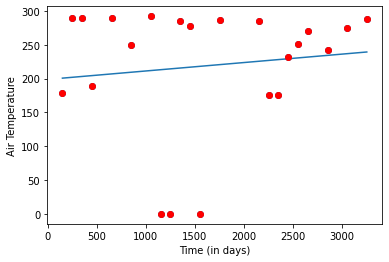

slope = 0.012464547473124634
y-int = 198.74930723874883


[178.45408163265307,
 289.68147208121826,
 290.060157790927,
 189.54237288135593,
 288.89328063241106,
 249.01169590643275,
 292.078431372549,
 0.0024875621890547263,
 0.00205620287868403,
 285.6036585365854,
 277.27127659574467,
 0.0,
 286.0426934547167,
 284.86816350028784,
 176.12608695652173,
 175.1060262800181,
 231.80574162679426,
 250.6385767790262,
 269.63987138263667,
 242.09566463633107,
 273.9935567010309,
 287.7982062780269]

In [ ]:
# calculate the average air temperature over each time interval (100 days) and plot average air temp over time.
temp_means = []
time = 0
times = []
while time < 3400:
    X_sub = X_new[X_new['date_delta'].between(time, time+100)]
    time += 100
    temp_mean = X_sub["AIR_TEMP"].mean()
    if temp_mean >= 0:
        temp_means.append(temp_mean)
        times.append(time+50)

#define data
x = np.array(times)
y = np.array(temp_means)

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b)        
plt.plot(times, temp_means, 'ro')
plt.xlabel("Time (in days)")
plt.ylabel("Air Temperature")
plt.show()

print("slope = " + str(a))
print("y-int = " + str(b))
temp_means

In [ ]:
# sanity check to see if there are any outliers in each feature distribution
for col in X.columns:
    print(col)
    print("\tMin: " + str(X[col].min()))
    print("\tMax: " + str(X[col].max()))
    print("\tAvg: " + str(X[col].mean()))
    print("\tSTD: " + str(X[col].std()))

WIND_SPEED
	Min: 0.0
	Max: 324.0
	Avg: 62.29042832167832
	STD: 43.52102513309643
SEA_LVL_PRES
	Min: 0.0
	Max: 10350.0
	Avg: 9738.123616236162
	STD: 1871.0581819572783
DEW_PT_TEMP
	Min: -116.0
	Max: 320.0
	Avg: 197.91359964093357
	STD: 87.64143384276312
SEA_SURF_TEMP
	Min: -15.0
	Max: 342.0
	Avg: 255.8073069320428
	STD: 56.19100468622841
SOURCE_ID
	Min: 5
	Max: 994
	Avg: 100.1652827008403
	STD: 145.29510791032322
TOT_CLD_AMT
	Min: 0.0
	Max: 9.0
	Avg: 5.099142615626132
	STD: 2.4703948498324126
ONE_BOX_NUM
	Min: 0
	Max: 992
	Avg: 139.95419279676773
	STD: 242.49539867094975
TEN_BOX_NUM
	Min: 0.0
	Max: 262.0
	Avg: 204.47822994462226
	STD: 71.53251547941531
PLATFORM_ID
	Min: 0
	Max: 149
	Avg: 8.364548992390253
	STD: 16.678862739902343
DECK
	Min: 2
	Max: 994
	Avg: 669.8902659693132
	STD: 282.8037123090621
WIND_DIR
	Min: 0.0
	Max: 362.0
	Avg: 161.94201312910283
	STD: 103.02000637850296
AIR_TEMP
	Min: -54.0
	Max: 350.0
	Avg: 234.9847133757962
	STD: 70.28617412753606
date_delta
	Min: 0.0
	Max: 3

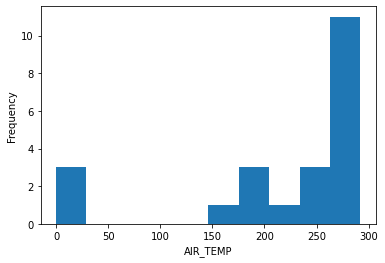

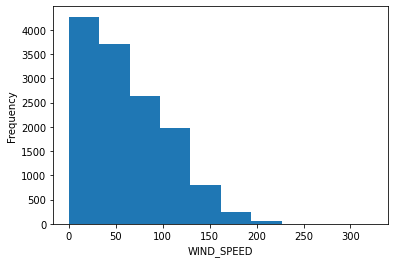

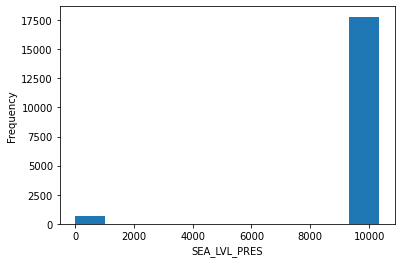

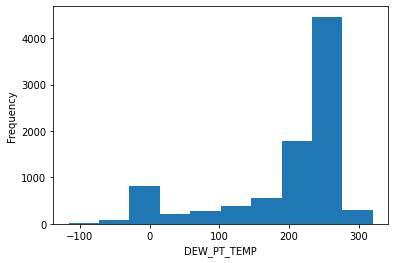

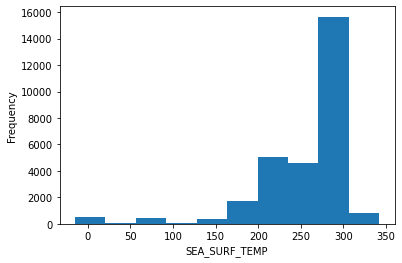

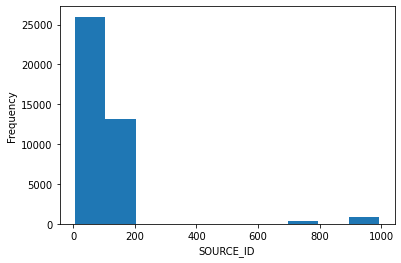

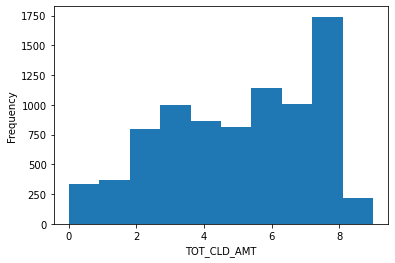

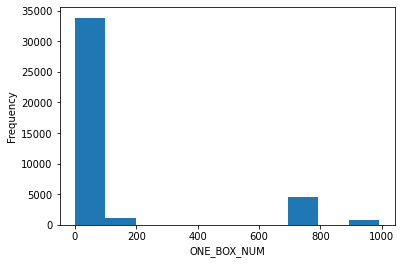

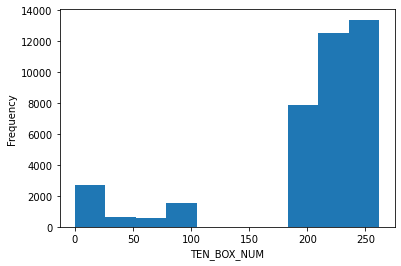

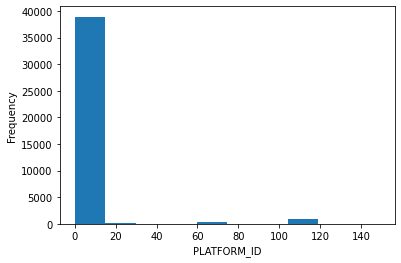

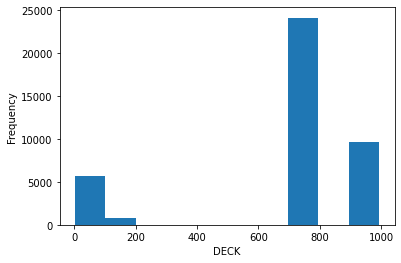

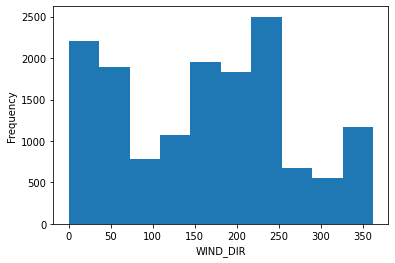

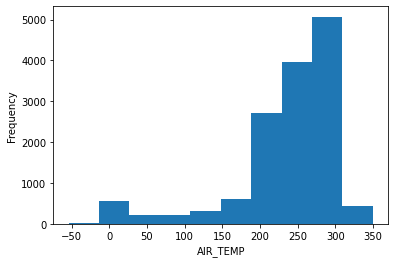

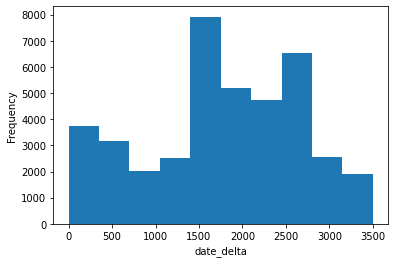

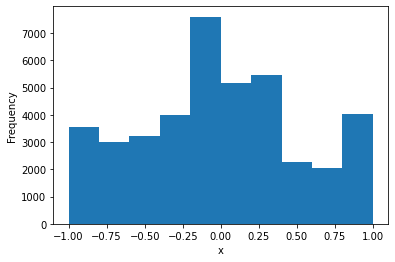

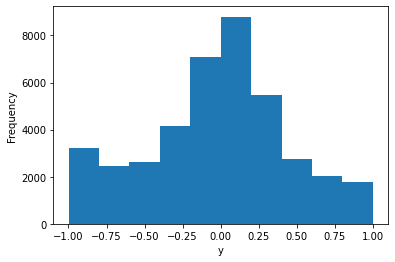

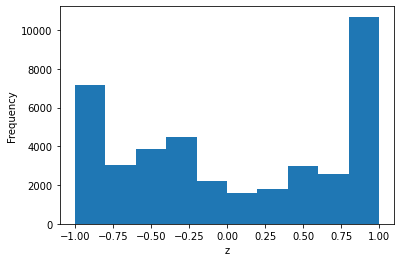

In [ ]:
### DATA EXPLORATION: hist
import numpy as np
import matplotlib.pyplot as plt


figResponse = plt.figure()
axResp = figResponse.add_subplot(1, 1, 1)
n, bins, patches = axResp.hist(y)
axResp.set_xlabel("AIR_TEMP")
axResp.set_ylabel('Frequency')

for col in X.columns:
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 1, 1)
    n, bins, patches = ax1.hist(X[col])
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')

### Data Scaling

In [ ]:
# instantiate a MinMaxScaler object, fit it, and transform data
def scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    np_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(np_scaled)
    df_scaled.columns = df.columns
    return df_scaled


In [ ]:
# split data table into features and response variable
X_multi = X_new.loc[:, X_new.columns != 'AIR_TEMP']
y = X_new['AIR_TEMP']

# max-min scale the feature set
X_multi = scaler(X_multi)
X_multi



,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,date_delta,x,y,z,WIND_DIR
0,0.268519,0.977488,0.763761,0.789916,0.108190,0.222222,0.012097,0.996183,0.033557,0.931452,0.000000,0.749932,0.364372,0.088585,0.082873
1,0.191358,0.980000,0.688073,0.798319,0.108190,0.666667,0.010081,0.996183,0.033557,0.931452,0.000000,0.413271,0.447425,0.010411,0.055249
2,0.475309,0.978357,0.727064,0.775910,0.108190,0.222222,0.079637,0.996183,0.033557,0.931452,0.000000,0.552644,0.530048,0.003670,0.138122
3,0.268519,0.979130,0.628440,0.798319,0.110212,0.888889,0.053427,0.996183,0.033557,0.997984,0.000000,0.002366,0.548628,0.503981,0.055249
4,0.287037,0.984541,0.252294,0.582633,0.931244,0.333333,0.191532,0.011450,0.751678,0.036290,0.000000,0.605411,0.488881,0.988671,0.939227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38439,0.302469,0.968116,0.855505,0.882353,0.108190,0.777778,0.033266,0.996183,0.033557,0.931452,0.999979,0.841909,0.645625,0.834785,0.690608
38440,0.475309,0.972464,0.850917,0.845938,0.110212,0.888889,0.008065,0.996183,0.033557,0.997984,0.999979,0.463683,0.689310,0.038612,0.690608
38441,0.287037,0.967633,0.830275,0.873950,0.108190,0.777778,0.069556,0.996183,0.033557,0.931452,0.999979,0.275252,0.449833,0.056216,0.911602
38442,0.268519,0.968116,0.788991,0.868347,0.110212,0.333333,0.041331,0.996183,0.033557,0.997984,0.999979,0.525085,0.436319,0.995304,0.607735


In [ ]:
data1 = X_multi['DEW_PT_TEMP']
data2 = y
data3 = X_multi['SEA_SURF_TEMP']
# calculate Spearman's correlation
corr_1, _ = spearmanr(data1, data2)
corr_2, _ = spearmanr(data2, data3)
corr_3, _ = spearmanr(data1, data3)

print('Spearmans correlation between Dew Point Temperature and Air Temperature: %.3f' % corr_1)
print('Spearmans correlation between Sea Surface Temperature and Air Temperature: %.3f' % corr_2)
print('Spearmans correlation between Sea Surface Temperature and Dew Point Temperature: %.3f' % corr_3)

### Splitting data between training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_multi, y, test_size = 0.25, random_state=42)

### Linear Regression

In [ ]:
# instantiate Linear Regression object and fit with training data
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# calcualate predicted target value with trained model to calculate MSE and R2
Y_train_predict = mlr.predict(X_train)
mse = mean_squared_error(y_train, Y_train_predict)
mae = mean_absolute_error(y_train, Y_train_predict)
ev = explained_variance_score(y_train, Y_train_predict)
r2 = r2_score(y_train, Y_train_predict)

print("--------------------------------------")
print("Coefficints of linear regression model:")
print("--------------------------------------")
coeff_df = pd.DataFrame(mlr.coef_, X_train.columns, columns=['Coefficient'])  
print(coeff_df)
print("--------------------------------------")
print("Linear Regression model performance (training set):")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Explained Variance is {}'.format(ev))


--------------------------------------
Coefficints of linear regression model:
--------------------------------------
               Coefficient
WIND_SPEED       -5.462514
SEA_LVL_PRES     27.621547
DEW_PT_TEMP     227.558716
SEA_SURF_TEMP   162.475584
SOURCE_ID        83.004331
TOT_CLD_AMT     -21.136998
ONE_BOX_NUM      22.143101
TEN_BOX_NUM      34.894543
PLATFORM_ID    -166.649952
DECK            -20.941541
date_delta       -6.612003
x                -5.636928
y                 0.511179
z                 2.840564
WIND_DIR          1.283218
--------------------------------------
Linear Regression model performance (training set):
--------------------------------------
MSE is 252.2515761231019
R2 is 0.9656452288252616
MAE is 9.469839376834711
Explained Variance is 0.9656452288252616


In [ ]:
# calcualate predicted target value with trained model to calculate MSE and R2
Y_test_predict = mlr.predict(X_test)
mse = mean_squared_error(y_test, Y_test_predict)
mae = mean_absolute_error(y_test, Y_test_predict)
ev = explained_variance_score(y_test, Y_test_predict)
r2 = r2_score(y_test, Y_test_predict)

print("--------------------------------------")
print("Linear Regression model performance (testing set):")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Explained Variance is {}'.format(ev))

--------------------------------------
Linear Regression model performance (testing set):
--------------------------------------
MSE is 259.63680784468465
R2 is 0.9645276775519435
MAE is 9.52200737895743
Explained Variance is 0.9645299656218678


### Decision Tree Regression

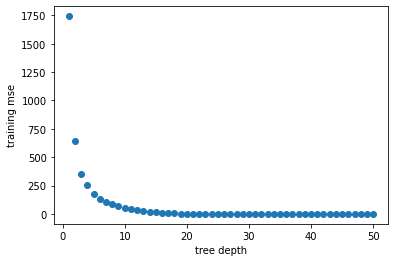

In [ ]:
# finding the optimal max_depth for the decision tree regression model
max_depth = 50
depths = []

train_mse = []
test_mse = []

# goes through depths from 0 - 50 and plots the training/testing mse against tree depth
for i in range(1, max_depth + 1):
    clf_graph = DecisionTreeRegressor(max_depth = i)
    clf_graph.fit(X_train, y_train)
    predictions_train = clf_graph.predict(X_train)
    predictions_test = clf_graph.predict(X_test)
    train_error = mean_squared_error(y_train, predictions_train)
    test_error = mean_squared_error(y_test, predictions_test)
    depths.append(i)
    train_mse.append(train_error)
    test_mse.append(test_error)

plt.plot(depths, train_mse, 'o')
plt.xlabel("tree depth")
plt.ylabel("training mse")
plt.show()

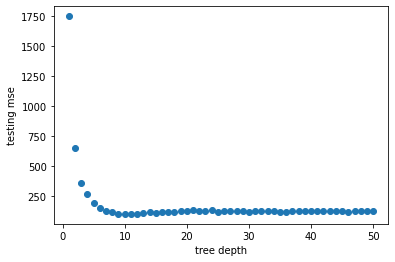

In [ ]:
plt.plot(depths, test_mse, 'o')
plt.xlabel("tree depth")
plt.ylabel("testing mse")
plt.show()

In [ ]:
# based off of the graph training mse vs tree depth, max_depth of 20 is the most optimal value to decrease the mse
dtr = DecisionTreeRegressor(criterion = "squared_error", max_depth = 20)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [ ]:
# calcualate predicted target value with trained model to calculate MSE and R2
Y_train_predict = dtr.predict(X_train)
mse = mean_squared_error(y_train, Y_train_predict)
mae = mean_absolute_error(y_train, Y_train_predict)
ev = explained_variance_score(y_train, Y_train_predict)
r2 = r2_score(y_train, Y_train_predict)
print("--------------------------------------")
print("Decision Tree model performance (training set):")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Explained Variance is {}'.format(ev))

--------------------------------------
Decision Tree model performance (training set):
--------------------------------------
MSE is 2.1615971532727554
R2 is 0.9997056066934685
MAE is 0.3144420409035397
Explained Variance is 0.9997056066934685


In [ ]:
# calcualate predicted target value with trained model to calculate MSE and R2
Y_test_predict = dtr.predict(X_test)
mse = mean_squared_error(y_test, Y_test_predict)
mae = mean_absolute_error(y_test, Y_test_predict)
ev = explained_variance_score(y_test, Y_test_predict)
r2 = r2_score(y_test, Y_test_predict)

print("--------------------------------------")
print("Decision Tree model performance (testing set):")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Explained Variance is {}'.format(ev))

--------------------------------------
Decision Tree model performance (testing set):
--------------------------------------
MSE is 124.69335906726495
R2 is 0.9829640370458904
MAE is 4.236314259384328
Explained Variance is 0.9829659021200531


In [ ]:
# shows the features with the most importance for the regression tree
importance = dtr.feature_importances_
# summarize feature importance
imp_df = pd.DataFrame(importance, X_train.columns, columns=['Scores'])  
print(imp_df)

                 Scores
WIND_SPEED     0.000879
SEA_LVL_PRES   0.004363
DEW_PT_TEMP    0.810823
SEA_SURF_TEMP  0.161799
SOURCE_ID      0.000763
TOT_CLD_AMT    0.001644
ONE_BOX_NUM    0.001152
TEN_BOX_NUM    0.001927
PLATFORM_ID    0.001399
DECK           0.006956
date_delta     0.004076
x              0.001080
y              0.001401
z              0.000856
WIND_DIR       0.000884


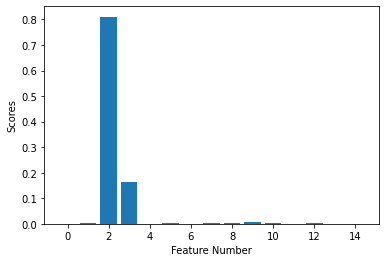

In [ ]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.rcParams["figure.figsize"] = (8,5.5)
pyplot.xlabel("Feature Number")
pyplot.ylabel("Scores")
pyplot.show()

The "importance" variable represents the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. In this case the criterion is MSE, so the feature reduces the MSE the most is DEW_PT_TEMP with a score of 0.8.

### Random Forest

In [ ]:
# creating the Random Forest Ensemble models for both training and testing
iterations = [10, 50, 100, 500]
for metric in iterations:
    table_training_rf_random = PrettyTable(["Model type", "# of Classifiers", "MSE", "R2", "MAE", "EV"])
    table_testing_rf_random = PrettyTable(["Model type", "# of Classifiers", "MSE", "R2", "MAE", "EV"])
    
    rf = RandomForestRegressor(n_estimators = metric)
    rf.fit(X_train, y_train)
    
    predictions_rf_train = rf.predict(X_train)
    predictions_rf_test = rf.predict(X_test)
    
    mse = mean_squared_error(y_train, predictions_rf_train)
    r2 = r2_score(y_train, predictions_rf_train)
    mae = mean_absolute_error(y_train, predictions_rf_train)
    ev = explained_variance_score(y_train, predictions_rf_train)

    table_training_rf_random.add_row(["training", metric, mse, r2, mae, ev])
    print(table_training_rf_random)
    
    mse = mean_squared_error(y_test, predictions_rf_test)
    r2 = r2_score(y_test, predictions_rf_test)
    mae = mean_absolute_error(y_test, predictions_rf_test)
    ev = explained_variance_score(y_test, predictions_rf_test)

    
    table_testing_rf_random.add_row(["testing", metric, mse, r2, mae, ev])
    print(table_testing_rf_random)

+------------+------------------+--------------------+--------------------+--------------------+-----------------+
| Model type | # of Classifiers |        MSE         |         R2         |        MAE         |        EV       |
+------------+------------------+--------------------+--------------------+--------------------+-----------------+
|  training  |        10        | 12.751934328720566 | 0.9982632822651435 | 1.3139232823500848 | 0.9982633129446 |
+------------+------------------+--------------------+--------------------+--------------------+-----------------+
+------------+------------------+-------------------+--------------------+--------------------+--------------------+
| Model type | # of Classifiers |        MSE        |         R2         |        MAE         |         EV         |
+------------+------------------+-------------------+--------------------+--------------------+--------------------+
|  testing   |        10        | 76.26008557902405 | 0.9895811292396041 |

In [ ]:
# shows the features with the most importance for the regression tree
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)
importance = rf.feature_importances_
# summarize feature importance
imp_df = pd.DataFrame(importance, X_train.columns, columns=['Scores'])  
print(imp_df)

                 Scores
WIND_SPEED     0.001350
SEA_LVL_PRES   0.003685
DEW_PT_TEMP    0.814779
SEA_SURF_TEMP  0.158269
SOURCE_ID      0.001840
TOT_CLD_AMT    0.001672
ONE_BOX_NUM    0.001251
TEN_BOX_NUM    0.001659
PLATFORM_ID    0.001267
DECK           0.005560
date_delta     0.003870
x              0.001246
y              0.001411
z              0.001076
WIND_DIR       0.001066


### Neural Networks

In [ ]:
# creating the Neural Network models for both training and testing
table_training_mlp = PrettyTable(["Model type", "MSE", "R2", "MAE", "EV"])
table_testing_mlp = PrettyTable(["Model type", "MSE", "R2", "MAE", "EV"])
    
mlp = MLPRegressor(hidden_layer_sizes = [20, 100, 20], max_iter = 300)
mlp.fit(X_train, y_train)
    
predictions_mlp_train = mlp.predict(X_train)
predictions_mlp_test = mlp.predict(X_test)
    
mse = mean_squared_error(y_train, predictions_mlp_train)
r2 = r2_score(y_train, predictions_mlp_train)
mae = mean_absolute_error(y_train, predictions_mlp_train)
ev = explained_variance_score(y_train, predictions_mlp_train)
    
table_training_mlp.add_row(["training", mse, r2, mae, ev])
print(table_training_mlp)
    
mse = mean_squared_error(y_test, predictions_mlp_test)
r2 = r2_score(y_test, predictions_mlp_test)
mae = mean_absolute_error(y_test, predictions_mlp_test)
ev = explained_variance_score(y_test, predictions_mlp_test)
    
table_testing_mlp.add_row(["testing", mse, r2, mae, ev])
print(table_testing_mlp)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


+------------+--------------------+--------------------+-------------------+--------------------+
| Model type |        MSE         |         R2         |        MAE        |         EV         |
+------------+--------------------+--------------------+-------------------+--------------------+
|  training  | 112.72078404939451 | 0.9846482753361897 | 5.636917551942669 | 0.9846577080276308 |
+------------+--------------------+--------------------+-------------------+--------------------+
+------------+--------------------+--------------------+-----------------+-------------------+
| Model type |        MSE         |         R2         |       MAE       |         EV        |
+------------+--------------------+--------------------+-----------------+-------------------+
|  testing   | 128.09547995706163 | 0.9824992295703558 | 5.8018295354968 | 0.982505414407911 |
+------------+--------------------+--------------------+-----------------+-------------------+


### Predicting 2021 Air Temperature

In [ ]:
# reading csv file of 2021 data set. The first row represents the features for the summer month 
# and the second row represents  the features for the winter month
df_2021 = pd.read_csv("TEST_DEMO.csv")

df_2021.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,IMMA_VER,ATTM_CT,TIME_IND,LL_IND,...,NCDC_QC_FLAGS,SOURCE_EXCLUSION_FLAG,OB_SOURCE,STA_WX_IND,PAST_WX2,DIR_OF_SWELL2,PER_OF_SWELL2,HGT_OF_SWELL2,CONCEN_OF_SEA_ICE,IND_FOR_PRECIP
0,V7HH2,2021-06-07T00:00:00,10,128,NaN,NaN,1,6,2,5,...,111A1111111111,NaN,5,NaN,2,NaN,NaN,NaN,NaN,NaN
1,DGTHCFK,2021-12-08T10:00:00,10,128,NaN,NaN,1,6,2,5,...,1.11111E+13,NaN,5,NaN,2,36.0,8.0,4.0,NaN,NaN


#### Cleaning the 2021 data

In [ ]:
X_ample = df_2021[columns]
X_ample ['DATE'] = pd.to_datetime(X_ample ['DATE'])    
X_ample ['date_delta'] = (X_ample ['DATE'] - X_ample ['DATE'].min())  / np.timedelta64(1,'D')
X_ample  = X_ample .drop(['DATE'], axis=1)
X_ample  = X_ample .sort_values('date_delta')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# convert latitude and longitude into X, Y, and Z axes
X_ample ['x'] = np.cos(X_ample ['LATITUDE']) * np.cos(X_ample ['LONGITUDE'])
X_ample ['y'] = np.cos(X_ample ['LATITUDE']) * np.sin(X_ample ['LONGITUDE'])
X_ample ['z'] = np.sin(X_ample ['LATITUDE'])
X_ample  = X_ample .drop(['LATITUDE'], axis=1)
X_ample  = X_ample .drop(['LONGITUDE'], axis=1)
X_ample.head()

,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,WIND_DIR,AIR_TEMP,date_delta,x,y,z
0,87,10067,287,290,172,6,1,261,5,798,240,300,0.000000,0.581389,-0.605002,-0.544021
1,77,10086,232,300,172,5,8,262,5,798,300,290,184.416667,0.581389,-0.605002,-0.544021


#### Splitting the data between feature set and target variable

In [ ]:
# split data table into features and response variable
X_ample_2 = X_ample.loc[:, X_ample.columns != 'AIR_TEMP']
y_2021 = X_ample['AIR_TEMP']
# max-min scale the feature set
X_ample_3 = scaler(X_ample_2)
X_ample_3.head()

,WIND_SPEED,SEA_LVL_PRES,DEW_PT_TEMP,SEA_SURF_TEMP,SOURCE_ID,TOT_CLD_AMT,ONE_BOX_NUM,TEN_BOX_NUM,PLATFORM_ID,DECK,WIND_DIR,date_delta,x,y,z
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


#### Predictions

In [ ]:
table_predictions = PrettyTable(["Model type", "Prediction", "MSE"])
table_predictions.add_row(["Linear Regression", mlr.predict(X_ample_3), mean_squared_error(y_2021, mlr.predict(X_ample_3))])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
table_predictions.add_row(["Decision Tree Regressor", dtr.predict(X_ample_2), mean_squared_error(y_2021, dtr.predict(X_ample_2))])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
table_predictions.add_row(["Random Forest", rf.predict(X_ample_2), mean_squared_error(y_2021, rf.predict(X_ample_2))])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
table_predictions.add_row(["Neural Network", mlp.predict(X_ample_3), mean_squared_error(y_2021, mlp.predict(X_ample_3))])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


```
print(table_predictions)

```

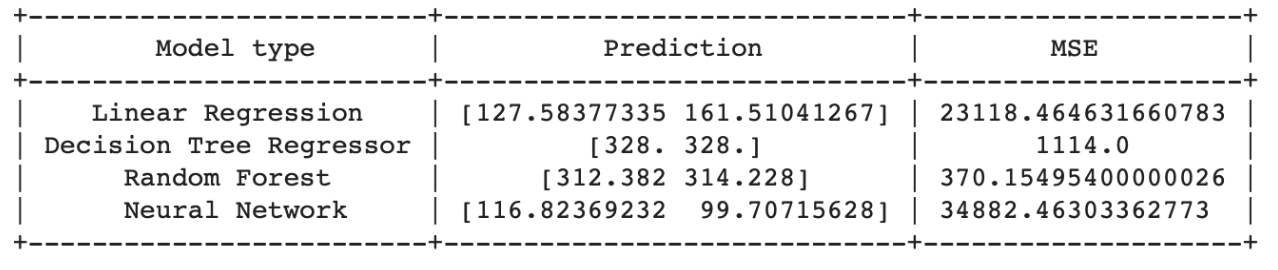